In [1]:
# logging 
import logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)


In [12]:
# environment setup
import gym
# noinspection PyUnresolvedReferences
import gym_woods

maze = gym.make('Woods1-v0')
print("This is how maze looks like")
situation = maze.reset()
print(type(situation))
print(situation)
maze.render()

This is how maze looks like
<class 'list'>
['O', 'O', '.', '.', '.', '.', '.', 'O']

□ □ □ □ □
□ ■ ■ $ □
□ ■ ■ ■ □
□ ■ ■ ■ □
□ □ X □ □


In [3]:
from lcs.agents.xncs import XNCS, Configuration

def cl_accuracy(cl, cfg):
     if cl.error < cfg.epsilon_0:
        return 1
     else:
        return cfg.alpha * pow(1/(cl.error * cfg.epsilon_0), cfg.v)
            
def fraction_accuracy(xncs):
    action_sets_percentages = []
    for action in range(xncs.cfg.number_of_actions):
        action_set = xncs.population.generate_action_set(action)
        total_accuracy = 0
        most_numerous = action_set[0]
        for cl in action_set:
            total_accuracy += cl_accuracy(cl, xncs.cfg)
            if cl.numerosity > most_numerous.numerosity:
                most_numerous = cl
        action_sets_percentages.append(cl_accuracy(most_numerous, xncs.cfg) / total_accuracy)
    return sum(action_sets_percentages) / xncs.cfg.number_of_actions

def specificity(xncs, population):
    total_specificity = 0
    for cl in population:
        total_specificity += pow(2, cl.wildcard_number)
    return total_specificity / xncs.population.numerosity

def xcs_maze_metrics(xncs: XNCS, environment):
    return {
        'numerosity': xncs.population.numerosity,
        'population': len(xncs.population),
        'average_specificity': specificity(xncs, xncs.population),
        'fraction_accuracy': fraction_accuracy(xncs)
    }

In [4]:
cfg = Configuration(number_of_actions=8,
                    max_population=1800,
                    learning_rate=0.2,
                    mutation_chance=0.08,
                    chi=0.8,
                    ga_threshold=25,
                    deletion_threshold=25,
                    delta=0.1,
                    initial_error=0.01,
                    metrics_trial_frequency=50,
                    covering_wildcard_chance = 0.9,
                    user_metrics_collector_fcn=xcs_maze_metrics,
                    lmc=10,
                    lem=200
                   )

In [5]:
agent = XNCS(cfg)
explore_population, explore_metrics = agent.explore(maze, 3000, True)

INFO:lcs.agents.Agent:{'trial': 0, 'steps_in_trial': 34, 'reward': [1.2154254143180256e-40, 0, 0, 200.0, 4.702503583423768e-40, 2.218902903430096e-40, 4.707198185594372e-40, 9.723403314544204e-41], 'numerosity': 95, 'population': 95, 'average_specificity': 2.1578947368421053, 'fraction_accuracy': 0.0878982128982129}
INFO:lcs.agents.Agent:{'trial': 300, 'steps_in_trial': 39, 'reward': [3.228232039490774, 5.990008422037867, 3.671586962241837, 39.5880312857614, 206.7029882275803, 10.374190042465461, 27.810893004694684, 5.450449547785647], 'numerosity': 256, 'population': 128, 'average_specificity': 2.1875, 'fraction_accuracy': 0.034622683896827114}
INFO:lcs.agents.Agent:{'trial': 600, 'steps_in_trial': 14, 'reward': [1.5795658914874486, 0.12233902284133769, 0.14771896189035688, 0.4658073250086452, 54.67608523299567, 6.421396890904224, 284.46058233621267, 71.06564240621019], 'numerosity': 272, 'population': 128, 'average_specificity': 2.136029411764706, 'fraction_accuracy': 0.0027912531132

In [6]:
for cl in explore_population:
    print(str(cl))

Cond:.#.#O#.. - Act:0 - Num:3 [fit: 0.000, exp: 71.00, pred: 221.934]
Cond:...OO... - Act:1 - Num:1 [fit: 0.000, exp: 65.00, pred: 223.752]
Cond:...#O..# - Act:2 - Num:3 [fit: 0.000, exp: 37.00, pred: 215.597]
Cond:...O#... - Act:3 - Num:3 [fit: 0.000, exp: 116.00, pred: 200.400]
Cond:..#OO... - Act:4 - Num:3 [fit: 0.000, exp: 72.00, pred: 279.797]
Cond:...##... - Act:5 - Num:2 [fit: 0.000, exp: 410.00, pred: 252.168]
Cond:..#OO... - Act:6 - Num:3 [fit: 0.000, exp: 330.00, pred: 232.078]
Cond:...O#... - Act:7 - Num:3 [fit: 0.000, exp: 830.00, pred: 338.851]
Cond:.O...... - Act:0 - Num:3 [fit: 0.000, exp: 34.00, pred: 203.700]
Cond:#O##.#.. - Act:1 - Num:2 [fit: 0.000, exp: 106.00, pred: 282.097]
Cond:.O.....# - Act:2 - Num:3 [fit: 0.000, exp: 81.00, pred: 324.131]
Cond:.##.##.# - Act:3 - Num:2 [fit: 0.000, exp: 1005.00, pred: 204.173]
Cond:.O#..... - Act:4 - Num:3 [fit: 0.000, exp: 137.00, pred: 199.891]
Cond:.O#....# - Act:5 - Num:3 [fit: 0.000, exp: 226.00, pred: 186.277]
Cond:#O.#.#

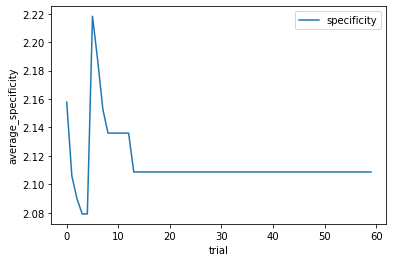

In [7]:
import pandas as pd
import numpy as np

df = pd.DataFrame(metric["average_specificity"] for metric in explore_metrics)
ax = df.plot()
ax.set_xlabel("trial")
ax.set_ylabel("average_specificity")
ax.legend(["specificity"])


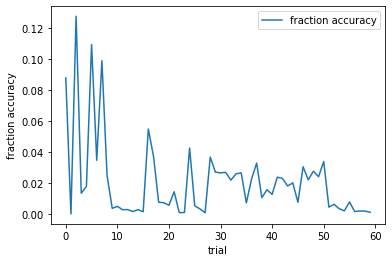

In [8]:
df = pd.DataFrame(metric["fraction_accuracy"] for metric in explore_metrics)
ax = df.plot()
ax.set_xlabel("trial")
ax.set_ylabel("fraction accuracy")
ax.legend(["fraction accuracy"])


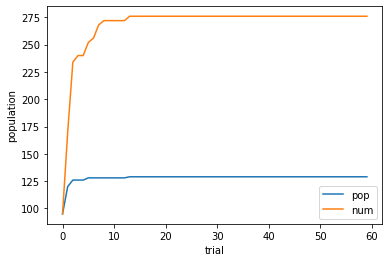

In [9]:

df = pd.DataFrame(zip([metric["population"] for metric in explore_metrics], [metric["numerosity"] for metric in explore_metrics]))
ax = df.plot()
ax.set_xlabel("trial")
ax.set_ylabel("population")
ax.legend(["pop", "num"])

steps_averaged = []


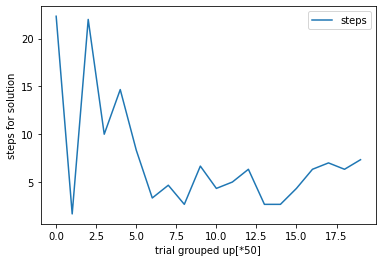

In [10]:


xf = [metric["steps_in_trial"] for metric in explore_metrics]
temp_df = np.array_split(xf, 20)
for i in range(len(temp_df)):
    temp_df[i] = np.mean(temp_df[i]) 
df = pd.DataFrame(temp_df)
# df = pd.DataFrame(metric["steps_in_trial"] for metric in explore_metrics)
ax = df.plot()
ax.set_xlabel("trial grouped up[*50]")
ax.set_ylabel("steps for solution")
ax.legend(["steps"])
